# <center><span style='color:blue'>Projet 7 : Implémentez un modèle de scoring </span></center>

In [85]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# <a id='1'>1. Introduction</a>

----------------------------------------------------------------------------------------------------------------------------
Les données sont issues d'un concours organisé sur Kaggle par l'entreprise "**Home Credit**".

Home Credit est un service dédié à la fourniture de prêts à la population non bancarisée.
Prédire si un client remboursera ou non un prêt ou s'il aura des difficultés est un besoin commercial essentiel,
et Home Credit organise cette compétition sur Kaggle pour voir quel type de modèles la communauté
de l'apprentissage automatique peut développer pour l'aider dans cette tâche.

Il y a 7 sources de données différentes :

   *  **application_train/application_test** : les principales données de train et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de train sont accompagnées de la caractéristique TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
   
   
   *  **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans bureau, mais un prêt existant dans application_(train|test) peut avoir plusieurs crédits précédents.
   
   
   *  **bureau_balance** : données mensuelles concernant les crédits précédents dans bureau. Chaque ligne correspond à un mois de crédit précédent, et un crédit précédent unique peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
   
   
  * **previous_application** : demandes précédentes de prêts a Home Credit des clients qui ont des prêts dans les données de application_(train|test). Chaque prêt actuel dans les données de application_(train|test) peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
  
  
  * **POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou en espèces que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt en espèces précédent, et un seul prêt précédent peut avoir plusieurs lignes.
  
  
  * **credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont eu avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
  
  
  *  **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

_________________


## <span style='color:blue'>Importation des librairies </span>

In [86]:
import numpy as np
import glob
from numpy import mean, std,percentile
import pandas as pd
from pandas.core.reshape.pivot import pivot_table
import matplotlib.pyplot as plt
from matplotlib import style
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)
from scipy import stats, spatial
from scipy.stats import shapiro
import sklearn
import math
import warnings
warnings.filterwarnings("ignore")
import missingno
from IPython.display import display
from IPython.core.display import HTML
from haversine import haversine
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import plotly.graph_objects as go
color = sns.color_palette()
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.offline as pyo



import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [87]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

## Structure des données

In [88]:
## Affichage des descriptions des images

from IPython.display import Image
# URL of the image
url = 'https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png'
# Display the image
Image(url=url)

# <a id='2'>2. Importation des données </a>

In [154]:
application_test = pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/application_test.csv")
application_train = pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/application_train.csv")
bureau=pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/bureau.csv")
bureau_balance=pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/bureau_balance.csv")
credit_card_balance=pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/credit_card_balance.csv")
installments_payments=pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/installments_payments.csv")
POS_CASH_balance=pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/POS_CASH_balance.csv")
previous_application=pd.read_csv("C:/Users/gansane080944/Desktop/Formation_Data_Science/Projet7/donnee/previous_application.csv")

In [90]:
liste_df = [bureau, bureau_balance,credit_card_balance,installments_payments,POS_CASH_balance,
            previous_application,application_test,application_train]

In [91]:
print('Taille de la base application_train', application_train.shape)
print('Taille de la base application_test', application_test.shape)
print('Taille de la base POS_CASH_balance', POS_CASH_balance.shape)
print('Taille de la base bureau_balance', bureau_balance.shape)
print('Taille de la base previous_application', previous_application.shape)
print('Taille de la base installments_payments', installments_payments.shape)
print('Taille de la base credit_card_balance', credit_card_balance.shape)
print('Taille de la base bureau data', bureau.shape)

Taille de la base application_train (307511, 122)
Taille de la base application_test (48744, 121)
Taille de la base POS_CASH_balance (10001358, 8)
Taille de la base bureau_balance (27299925, 3)
Taille de la base previous_application (1670214, 37)
Taille de la base installments_payments (13605401, 8)
Taille de la base credit_card_balance (3840312, 23)
Taille de la base bureau data (1716428, 17)


# <a id='3'>3. Apperçues des bases </a>

**application_train data**

In [92]:
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [93]:
application_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

In [151]:
NUMERIC_FEATURES = application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns


In [152]:
application_train[NUMERIC_FEATURES].describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

Dans la base de données application_train, les features numériques ne sont pas bien identifiées et contiennent des features catégorielles représentées comme des features numériques :

 - **SK_ID_CURR** est un index et non un features.
 
 
 - **TARGET** , **children** représente le nombre d'enfants du demandeur.
 
 
 - **FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, .... FLAG_DOCUMENT_20 ,FLAG_DOCUMENT_21** :Ces features sont des features binaires indiquant la présence ou l'absence de documents spécifiques dans le dossier du demandeur. Chaque indicateur représente un type de document différent (par exemple, documents d'identification, documents relatifs aux revenus, etc.)
 
 
 - **Une autre constatation est que le groupe :**
    - **AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR** représentent le nombre de demandes de renseignements ou de requêtes adressées au bureau de crédit par le demandeur dans des intervalles de temps spécifiques. Chaque feature correspond à une unité de temps différente (heure, jour, semaine, mois, trimestre, année).

**POS_CASH_balance data**

In [94]:
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

**bureau_balance data**

In [95]:
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

**previous_application data**

In [96]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [97]:
previous_application.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT',
       'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO',
       'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA',
       'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

**installments_payments data**

In [98]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

**credit_card_balance data**

In [99]:
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [100]:
credit_card_balance.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
       'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT',
       'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT',
       'CNT_DRAWINGS_POS_CURRENT', 'CNT_INSTALMENT_MATURE_CUM',
       'NAME_CONTRACT_STATUS', 'SK_DPD', 'SK_DPD_DEF'], dtype=object)

**bureau data**

In [101]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

# <a id='4'>4. Vérification des données manquantes</a>

**Vérification données manquantes dans application_train **

In [102]:
# checking missing data
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_application_train_data.head(20)

Total    Percent
COMMONAREA_MEDI           214865  69.872297
COMMONAREA_AVG            214865  69.872297
COMMONAREA_MODE           214865  69.872297
NONLIVINGAPARTMENTS_MODE  213514  69.432963
NONLIVINGAPARTMENTS_AVG   213514  69.432963
NONLIVINGAPARTMENTS_MEDI  213514  69.432963
FONDKAPREMONT_MODE        210295  68.386172
LIVINGAPARTMENTS_MODE     210199  68.354953
LIVINGAPARTMENTS_AVG      210199  68.354953
LIVINGAPARTMENTS_MEDI     210199  68.354953
FLOORSMIN_AVG             208642  67.848630
FLOORSMIN_MODE            208642  67.848630
FLOORSMIN_MEDI            208642  67.848630
YEARS_BUILD_MEDI          204488  66.497784
YEARS_BUILD_MODE          204488  66.497784
YEARS_BUILD_AVG           204488  66.497784
OWN_CAR_AGE               202929  65.990810
LANDAREA_MEDI             182590  59.376738
LANDAREA_MODE             182590  59.376738
LANDAREA_AVG              182590  59.376738

**Vérification données manquantes dans POS_CASH_balance **

In [103]:
# checking missing data
total = POS_CASH_balance.isnull().sum().sort_values(ascending = False)
percent = (POS_CASH_balance.isnull().sum()/POS_CASH_balance.isnull().count()*100).sort_values(ascending = False)
missing_POS_CASH_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_POS_CASH_balance_data.head(3)

Total   Percent
CNT_INSTALMENT_FUTURE  26087  0.260835
CNT_INSTALMENT         26071  0.260675
SK_ID_PREV                 0  0.000000

**Vérification données manquantes dans bureau_balance **

In [104]:
# checking missing data
total = bureau_balance.isnull().sum().sort_values(ascending = False)
percent = (bureau_balance.isnull().sum()/bureau_balance.isnull().count()*100).sort_values(ascending = False)
missing_bureau_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_balance_data.head(3)

Total  Percent
SK_ID_BUREAU        0      0.0
MONTHS_BALANCE      0      0.0
STATUS              0      0.0

**Vérification données manquantes dans previous_application **

In [105]:
# checking missing data
total = previous_application.isnull().sum().sort_values(ascending = False)
percent = (previous_application.isnull().sum()/previous_application.isnull().count()*100).sort_values(ascending = False)
missing_previous_application_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_previous_application_data.head(15)

Total    Percent
RATE_INTEREST_PRIVILEGED   1664263  99.643698
RATE_INTEREST_PRIMARY      1664263  99.643698
AMT_DOWN_PAYMENT            895844  53.636480
RATE_DOWN_PAYMENT           895844  53.636480
NAME_TYPE_SUITE             820405  49.119754
NFLAG_INSURED_ON_APPROVAL   673065  40.298129
DAYS_TERMINATION            673065  40.298129
DAYS_LAST_DUE               673065  40.298129
DAYS_LAST_DUE_1ST_VERSION   673065  40.298129
DAYS_FIRST_DUE              673065  40.298129
DAYS_FIRST_DRAWING          673065  40.298129
AMT_GOODS_PRICE             385515  23.081773
AMT_ANNUITY                 372235  22.286665
CNT_PAYMENT                 372230  22.286366
PRODUCT_COMBINATION            346   0.020716

**Vérification données manquantes dans installments_payments **

In [106]:
# checking missing data
total = installments_payments.isnull().sum().sort_values(ascending = False)
percent = (installments_payments.isnull().sum()/installments_payments.isnull().count()*100).sort_values(ascending = False)
missing_installments_payments_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_installments_payments_data.head(3)

Total   Percent
DAYS_ENTRY_PAYMENT   2905  0.021352
AMT_PAYMENT          2905  0.021352
SK_ID_PREV              0  0.000000

**Vérification données manquantes dans credit_card_balance **

In [107]:
# checking missing data
total = credit_card_balance.isnull().sum().sort_values(ascending = False)
percent = (credit_card_balance.isnull().sum()/credit_card_balance.isnull().count()*100).sort_values(ascending = False)
missing_credit_card_balance_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_credit_card_balance_data.head(10)

Total    Percent
AMT_PAYMENT_CURRENT         767988  19.998063
AMT_DRAWINGS_ATM_CURRENT    749816  19.524872
CNT_DRAWINGS_POS_CURRENT    749816  19.524872
AMT_DRAWINGS_OTHER_CURRENT  749816  19.524872
AMT_DRAWINGS_POS_CURRENT    749816  19.524872
CNT_DRAWINGS_OTHER_CURRENT  749816  19.524872
CNT_DRAWINGS_ATM_CURRENT    749816  19.524872
CNT_INSTALMENT_MATURE_CUM   305236   7.948208
AMT_INST_MIN_REGULARITY     305236   7.948208
SK_ID_PREV                       0   0.000000

**Vérification données manquantes dans  bureau **

In [108]:
# checking missing data
total = bureau.isnull().sum().sort_values(ascending = False)
percent = (bureau.isnull().sum()/bureau.isnull().count()*100).sort_values(ascending = False)
missing_bureau_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_bureau_data.head(8)

Total    Percent
AMT_ANNUITY             1226791  71.473490
AMT_CREDIT_MAX_OVERDUE  1124488  65.513264
DAYS_ENDDATE_FACT        633653  36.916958
AMT_CREDIT_SUM_LIMIT     591780  34.477415
AMT_CREDIT_SUM_DEBT      257669  15.011932
DAYS_CREDIT_ENDDATE      105553   6.149573
AMT_CREDIT_SUM               13   0.000757
CREDIT_ACTIVE                 0   0.000000

# <a id='5'>5. Exploration des données</a>

In [109]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

## <a id='5-1'>5.1 Distribution de la variable AMT_CREDIT</a>

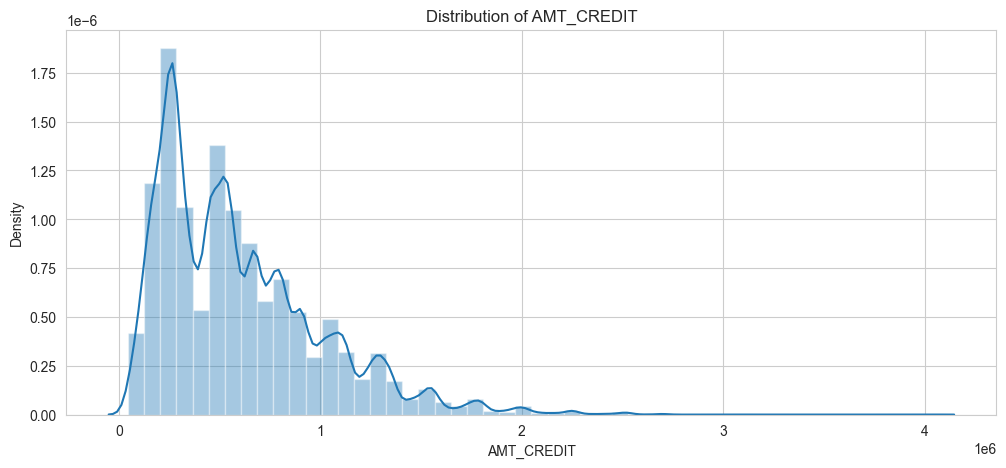

In [110]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.distplot(application_train["AMT_CREDIT"])

## <a id='5-2'>5.2 Distribution de la variable AMT_INCOME_TOTAL</a>

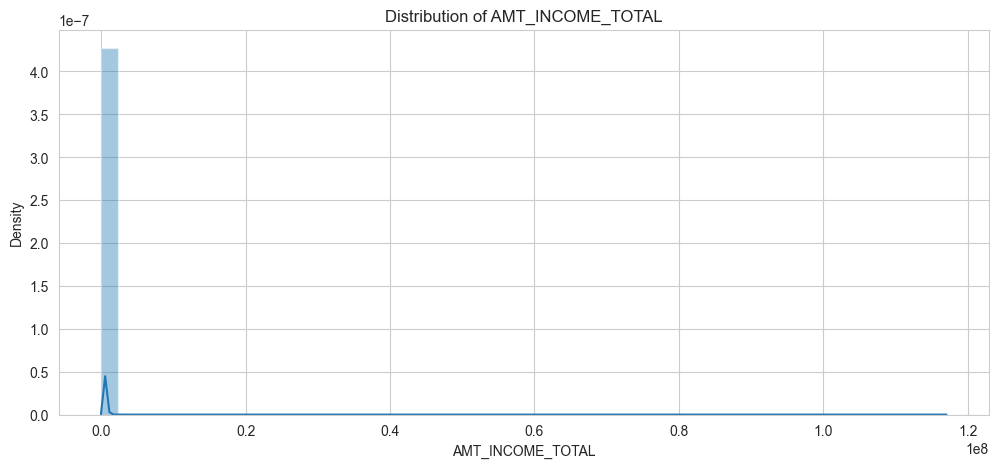

In [111]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_INCOME_TOTAL")
ax = sns.distplot(application_train["AMT_INCOME_TOTAL"].dropna())

## <a id='5-3'>5.3 Distribution de la variable AMT_GOODS_PRICE</a>

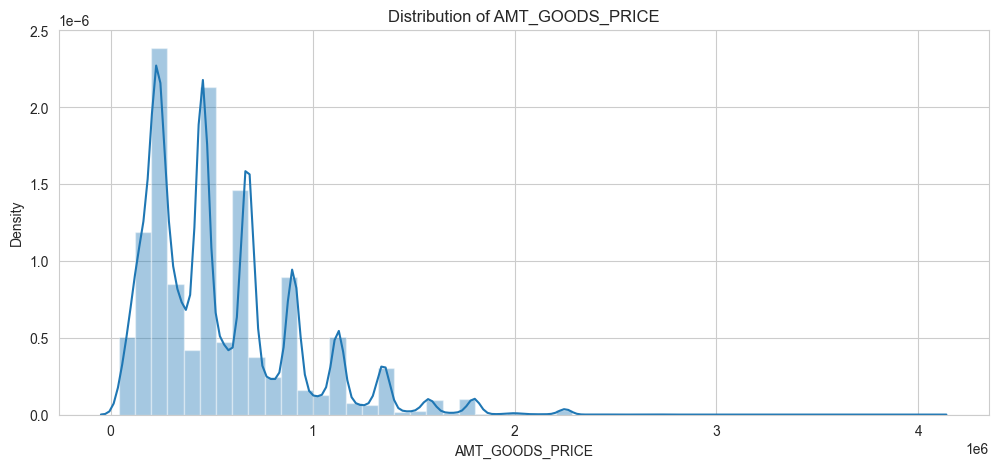

In [112]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.distplot(application_train["AMT_GOODS_PRICE"].dropna())

## <a id='5-4'>5.4 Qui a accompagné le client lors de l'introduction de la demande</a>

In [113]:
temp = application_train["NAME_TYPE_SUITE"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Qui a accompagné le client lors de l'introduction de la demande",
    xaxis=dict(
        title='Nom de l\'accompagnant',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Nombre de l\'accompagant',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

## <a id='5-5'>5.5 Equilibre des données</a>

In [114]:
import plotly.express as px

# Exemple de données
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                   })

# Tracer le graphique circulaire interactif avec Plotly Express
fig = px.pie(df, values='values', names='labels', title='Prêt remboursé ou non')

# Afficher le graphique interactif
fig.show()

In [115]:
# !pip install plotly

* Comme nous pouvons le constater, les données sont fortement déséquilibrées.

## <a id='5-6'>5.6 Types de prêt</a>

**Prêts renouvelables :** Arrangement qui permet de retirer, de rembourser et de ré-tirer le montant du prêt de n'importe quelle manière et n'importe quel nombre de fois, jusqu'à l'expiration de l'arrangement. Les prêts sur carte de crédit et les découverts sont des prêts renouvelables. Également appelé prêt à durée indéterminée

In [116]:
temp = application_train["NAME_CONTRACT_TYPE"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .48]},
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Types de prêts",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Types de prêts",
                "x": 0.17,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

* La plupart des prêts sont des prêts au comptant contractés par les demandeurs. **90,5 %** des prêts sont des prêts de trésorerie.

## <a id='5-7'>5.7 Objet du prêt</a>

In [117]:
# Exemple de données
temp1 = application_train["FLAG_OWN_CAR"].value_counts()
temp2 = application_train["FLAG_OWN_REALTY"].value_counts()

fig = {
  "data": [
    {
      "values": temp1.values,
      "labels": temp1.index,
      "domain": {"x": [0, .48]},
      "name": "Own Car",
      "hoverinfo": "label+percent+name",
      "hole": .6,
      "type": "pie"
    },
    {
      "values": temp2.values,
      "labels": temp2.index,
      "text": ["{}: {}%".format(label, value) for label, value in zip(temp2.index, temp2.values)],
      "textposition": "inside",
      "domain": {"x": [.52, 1]},
      "name": "Own Realty",
      "hoverinfo": "label+percent+name",
      "hole": .6,
      "type": "pie"
    }],
  "layout": {
        "title": "Objet du prêt",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Own Car",
                "x": 0.20,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Own Realty",
                "x": 0.8,
                "y": 0.5
            }
        ]
    }
}

iplot(fig, filename='donut')

## <a id='5-8'>5.8 Sources de revenus du demandeur du prêt</a>

In [118]:
temp = application_train["NAME_INCOME_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
fig=px.pie(df, values='values', names='labels', title='Sources de revenus du demandeur du prêt', hole = 0.5)
# Afficher le graphique interactif
fig.show()

* 51,6 % des demandeurs de prêts ont indiqué qu'ils travaillaient. 23,3 % sont associés commerciaux et 18 % sont retraités, etc.

## <a id='5-9'>5.9 Situation familiale du demandeur du prêt</a>

In [119]:
temp = application_train["NAME_FAMILY_STATUS"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })


fig=px.pie(df,values='values',names='labels', title='Situation familiale', hole = 0.5)

# Afficher le graphique interactif
fig.show()

* 63,9 % des demandeurs sont mariés. 14,8 % sont célibataires, etc.

## <a id='5-10'>5.10 Profession du demandeur du prêt</a>

In [120]:
# Exemple de données
temp = application_train["OCCUPATION_TYPE"].value_counts()

# Création du graphique à barres interactif
data = [go.Bar(x=temp.index, y=temp.values, marker=dict(color='green'))]
layout = go.Layout(title='Profession du demandeur du prêt',
                   xaxis=dict(title='Occupation'),
                   yaxis=dict(title='Count'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)


* **Top 5 des proféssions des demandeurs de prêts :**
  * Ouvriers - Environ 55 000
  * Personnel de vente - Environ 32 000
  * Personnel de base - Environ 28 000
  * Directeurs - Environ 21 000
  * Chauffeurs - Environ 19 000

## <a id='5-11'>5.11 Niveau d'etude du demandeur de prêt</a>

In [121]:
temp = application_train["NAME_EDUCATION_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
         
fig=px.pie(df,values='values',names='labels', title='Niveau d\'etude du demandeur de prêt', hole = 0.5)

# Afficher le graphique interactif
fig.show()

* 71 % des demanndeurs de prêts ont un niveau d'études secondaires et 24,3 % un niveau d'études supérieures.

## <a id='5-12'>5.12 Types d'habitations des demandeurs de prêts </a>

In [122]:
temp = application_train["NAME_HOUSING_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
fig=px.pie(df,values='values', names='labels', title='Types d\'habitations', hole = 0.5)

# Afficher le graphique interactif
fig.show()

* Environ 89 % des personnes qui ont demandé un prêt ont indiqué que le type d'habitation était **Maison / Appartement**.

## <a id='5-13'>5.13 Types d'organisations des demandeurs de prêt </a>

In [123]:
temp = application_train["ORGANIZATION_TYPE"].value_counts()

# Création du graphique à barres interactif
data = [go.Bar(x=temp.index, y=temp.values, marker=dict(color='red'))]
layout = go.Layout(title='Type d\'organisation',
                   xaxis=dict(title='Organisation'),
                   yaxis=dict(title='Nombre'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)


* **Types d'organisations des demandeurs de prêt :**
  * Business Entity Type 3 - Environ 68 K
  * XNA - Environ 55 K
  * Indépendants - Environ 38 K
  * Autres - Environ 17 K
  * Médecine - Environ 11 K

## <a id='5-14'>5.14 Exploration en termes de remboursement ou de non-remboursement du prêt</a>

## <a id='5-14-1'>5.14.1 Sources de revenus du demandeur selon le remboursement ou de non-remboursement du prêt (en %)</a>

In [124]:
temp = application_train["NAME_INCOME_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_INCOME_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_INCOME_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Sources de revenus du demandeur selon le remboursement ou de non-remboursement du prêt (en %)",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Income source',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-14-2'>5.14.2 Situation familiale du demandeur selon le statut de remboursement du prêt (en %)</a>

In [125]:
temp = application_train["NAME_FAMILY_STATUS"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_FAMILY_STATUS"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_FAMILY_STATUS"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Situation familiale du demandeur selon le statut de remboursement du prêt en %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Family Status',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-14-3'>5.14.3 Profession du demandeur selon le statut de remboursement du prêt %</a>

In [126]:
temp = application_train["OCCUPATION_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["OCCUPATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["OCCUPATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Profession du demandeur selon le statut de remboursement du prêt en %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Occupation of Applicant\'s',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-14-4'>5.14.4 Niveau d'education du demandeur selon le statut de remboursement du prêt %</a>

In [127]:
temp = application_train["NAME_EDUCATION_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_EDUCATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_EDUCATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Niveau d'education du demandeur selon le statut de remboursement du prêt en %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Education of Applicant\'s',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-14-5'>5.14.5 Pour quels types de logements les candidats ont-ils demandé un prêt en termes de remboursement ou de non-remboursement en %</a>

In [128]:
temp = application_train["NAME_HOUSING_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_HOUSING_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_HOUSING_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Pour quels types de logements les candidats ont-ils demandé un prêt en termes de remboursement ou de non-remboursement en %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='types of house',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-14-6'>5.14.6 Types d'organisation du demandeur selon le statut de remboursement du prêt en %</a>

In [129]:
temp = application_train["ORGANIZATION_TYPE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["ORGANIZATION_TYPE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["ORGANIZATION_TYPE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Types d'organisation du demandeur selon le statut de remboursement du prêt en %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Types of Organizations',
        tickfont=dict(
            size=10,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-14-7'>5.14.7 Répartition de l'accopagnant du demandeur de prêt selon le statut de remboursement en %.</a>

In [130]:
temp = application_train["NAME_TYPE_SUITE"].value_counts()
#print(temp.values)
temp_y0 = []
temp_y1 = []
for val in temp.index:
    temp_y1.append(np.sum(application_train["TARGET"][application_train["NAME_TYPE_SUITE"]==val] == 1))
    temp_y0.append(np.sum(application_train["TARGET"][application_train["NAME_TYPE_SUITE"]==val] == 0))    
trace1 = go.Bar(
    x = temp.index,
    y = (temp_y1 / temp.sum()) * 100,
    name='YES'
)
trace2 = go.Bar(
    x = temp.index,
    y = (temp_y0 / temp.sum()) * 100, 
    name='NO'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Répartition de l'accopagnant du demandeur de prêt selon le statut de remboursement en %",
    #barmode='stack',
    width = 1000,
    xaxis=dict(
        title='Name of type of the Suite',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

# <a id='5-15'>5.15 Exploitation des données selon le prêt précédent</a>

## <a id='5-15-1'>5.15.1 Type de produit contractuel selon la demande de prêt précédent</a>

In [131]:
temp = previous_application["NAME_CONTRACT_TYPE"].value_counts()
fig = {
  "data": [
    {
      "values": temp.values,
      "labels": temp.index,
      "domain": {"x": [0, .48]},
      #"name": "Types of Loans",
      #"hoverinfo":"label+percent+name",
      "hole": .7,
      "type": "pie"
    },
    
    ],
  "layout": {
        "title":"Type de produit contractuel selon la demande de prêt précédent",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Contract product type",
                "x": 0.12,
                "y": 0.5
            }
            
        ]
    }
}
iplot(fig, filename='donut')

* **Type de produit contractuel de la demande précédente :**
 * Prêts de trésorerie - 44,8
 * Prêts à la consommation - 43,7
 * Prêts renouvelables - 11,6 %.
 * XNA - 0.0207 %

## <a id='5-15-2'>5.15.2 Quel est le jour où le plus grand nombre de clients a déposé une demande de préfinancement ?</a>

In [132]:
temp = previous_application["WEEKDAY_APPR_PROCESS_START"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
)
data = [trace]
layout = go.Layout(
    title = "Quel est le jour où le plus grand nombre de clients a déposé une demande de préfinancement? en % ",
    xaxis=dict(
        title='Day of the Week',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count of Day of Week in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='schoolStateNames')

* Environ 15 % des clients ont déposé une demande pour chacun des 5 jours de la semaine, à savoir le mardi, le mercredi, le lundi, le vendredi et le jeudi. 

## <a id='5-15-3'>5.15.3 Objet de demande du prêt precedent</a>

In [133]:
temp = previous_application["NAME_CASH_LOAN_PURPOSE"].value_counts()
#print("Total number of states : ",len(temp))
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Blues',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = " Objet de demande du prêt precedent en % ",
    xaxis=dict(
        title='Purpose of cash loan',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

* **L'objectif principal du prêt de trésorerie était :**
  * XAP - 55 %
  * XNA - 41 %

## <a id='5-15-4'>5.15.4 Contrat de demande de prêt precedent a été approuvé ou non </a>

In [134]:
temp = previous_application["NAME_CONTRACT_STATUS"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

fig=px.pie(df,values='values', names='labels',
         title=' Contrat de demande de prêt precedent a été approuvé ou non', hole = 0.5)
# Afficher le graphique interactif
fig.show()


* **Le contrat a été approuvé ou non dans la demande précédente :**
  * Approuvé : 62,1 % fois
  * Annulé : 18,9 % des fois
  * Refusé : 17,4 fois
  * Offre non utilisée : 1,58 % fois

## <a id='5-15-5'>5.15.5 Mode de paiement choisi par le client pour rembourser le prêt precedent</a>

In [135]:
temp = previous_application["NAME_PAYMENT_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
fig=px.pie(df,values='values', names='labels',
         title='Mode de paiement choisi par le client pour rembourser le prêt precedent', hole = 0.5)
# Afficher le graphique interactif
fig.show()

* Comme nous pouvons le constater, la plupart des paiements (61,9 %) ont été effectués uniquement en espèces.. 

## <a id='5-15-6'>5.15.6 Motif de rejet de demande de prêt précédent</a>

In [136]:
temp = previous_application["CODE_REJECT_REASON"].value_counts()

# Création du graphique à barres interactif
data = [go.Bar(x=temp.index, y=temp.values, marker=dict(color='red'))]
layout = go.Layout(title='Motifs de rejet de demande de prêt precedent',
                   xaxis=dict(title='Motifs'),
                   yaxis=dict(title='Nombre'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

## <a id='5-15-7'>5.15.7 L'accompagnant du client pour la demande de prêt precedent</a>

In [137]:
# Exemple de données (remplacez cette ligne par vos données réelles)
temp = previous_application["NAME_TYPE_SUITE"].value_counts()

# Création du graphique à barres interactif
trace = go.Bar(
    x=temp.index,
    y=(temp / temp.sum()) * 100,
    marker=dict(
        color=(temp / temp.sum()) * 100,
        colorscale='viridis',  # Utilisation de la palette de couleurs 'Viridis'
        #reversescale=True
    ),
)
data = [trace]
layout = go.Layout(
    title="L'accompagnant du client pour la demande de prêt precedent en %",
    xaxis=dict(
        title='Acconpagnant',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Pourcentage du type d\'accompagnant dans les demandes de prêt précédentes',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


* **Qui a accompagné le client lors de l'introduction de la demande précédente ? :**
 * Non accompagné : Environ 60 % des fois
 * Famille : environ 25 % des fois
 * Conjoint, partenaire : Environ 8 %.
 * Enfants : environ 4 %.

## <a id='5-15-8'>5.15.8 Le client était-il un ancien ou un nouveau client lors de la demande précédente ?</a>

In [138]:
temp = previous_application["NAME_CLIENT_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

fig = px.pie(df, values='values', names='labels', title='Ancienneté du client', hole=0.7,
             color_discrete_sequence=['#ea7c96', '#75e575'])

# Afficher le graphique interactif
fig.show()


* Environ 74 % des clients étaient des répétiteurs qui avaient déposé une demande antérieure.

## <a id='5-15-9'>5.15.9 Quel type de biens le client a-t-il demandé dans la demande précédente ?</a>

In [139]:
temp = previous_application["NAME_GOODS_CATEGORY"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Greens',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Quel type de biens le client a-t-il demandé dans la demande précédente ? en % ",
    xaxis=dict(
        title='Name of the goods',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## <a id='5=15=10'>5.15.10 La demande de prêt precedent etait CASH, POS, CAR, …</a>

In [140]:
temp = previous_application["NAME_PORTFOLIO"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

fig = px.pie(df, values='values', names='labels', title='Ancienneté du client', hole=0.7,
             color_discrete_sequence=['#ea7c96', '#75e575'])

# Afficher le graphique interactif
fig.show()

## <a id='5-15-11'>5.15.11 La demande précédente était-elle une vente à l'étalage ou une demande sans rendez-vous ?</a>

In [141]:
temp = previous_application["NAME_PRODUCT_TYPE"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
fig=px.pie(df,values='values', names='labels',
         title='La demande précédente était-elle une vente à l\'étalage ou une demande sans rendez-vous ?', hole = 0.7)

# Afficher le graphique interactif
fig.show()

## <a id='5-15-12'>5.15.12 Principaux canaux par lesquels ils ont acquis le client lors de la demande précédente</a>

In [142]:
temp = previous_application["CHANNEL_TYPE"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
#         colorscale = 'Violet',
#         reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Principaux canaux par lesquels ils ont acquis le client lors de la demande précédente en % ",
    xaxis=dict(
        title='Name of the Channel',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

* **Principaux canaux par lesquels ils ont acquis le client lors de la demande précédente :**
  * Credidit and cash offices : 43 % times
  * Country_wide : 30 % times
  * Stone : 13 % times
 

## <a id='5-15-13'>5.15.13 Principal secteur d'activité du vendeur</a>

In [143]:
temp = previous_application["NAME_SELLER_INDUSTRY"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Greens',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Principal secteur d'activité du vendeur en % ",
    xaxis=dict(
        title='Industry Name',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## <a id='5-15-14'>5.15.14 Taux d'intérêt regroupés en taux faibles, moyens et élevés de la demande précédente</a>

In [144]:
temp = previous_application["NAME_YIELD_GROUP"].value_counts()
trace = go.Bar(
    x = temp.index,
    y = (temp / temp.sum())*100,
    marker=dict(
        color=(temp / temp.sum())*100,
        colorscale = 'Greens',
        reversescale = True
    ),
)
data = [trace]
layout = go.Layout(
    title = "Taux d'intérêt regroupés en taux faibles, moyens et élevés de la demande précédente en % ",
    xaxis=dict(
        title='Grouped Interest rate',
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    yaxis=dict(
        title='Count in %',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
)
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## <a id='5-15-15'>5.15.15 Top Combinaison détaillée de produits de la demande précédente</a>

In [145]:
temp = previous_application["PRODUCT_COMBINATION"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
fig=px.pie(df,values='values', names='labels',
         title='Combinaison détaillée de produits de la demande précédente', hole = 0.7)

# Afficher le graphique interactif
fig.show()

## <a id='5-15-16'>5.15.16 Le client a-t-il demandé une assurance lors de la précédente demande ?</a>

In [146]:
temp = previous_application["NFLAG_INSURED_ON_APPROVAL"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
fig=px.pie(df,values='values', names='labels',
         title='Le client a-t-il demandé une assurance lors de la précédente demande ?', hole = 0.7)

# Afficher le graphique interactif
fig.show()

## <a id='6'>6. Distribution des variables </a>

## <a id='6.1'>6.1 Distribution des variables : Methode graphique </a>

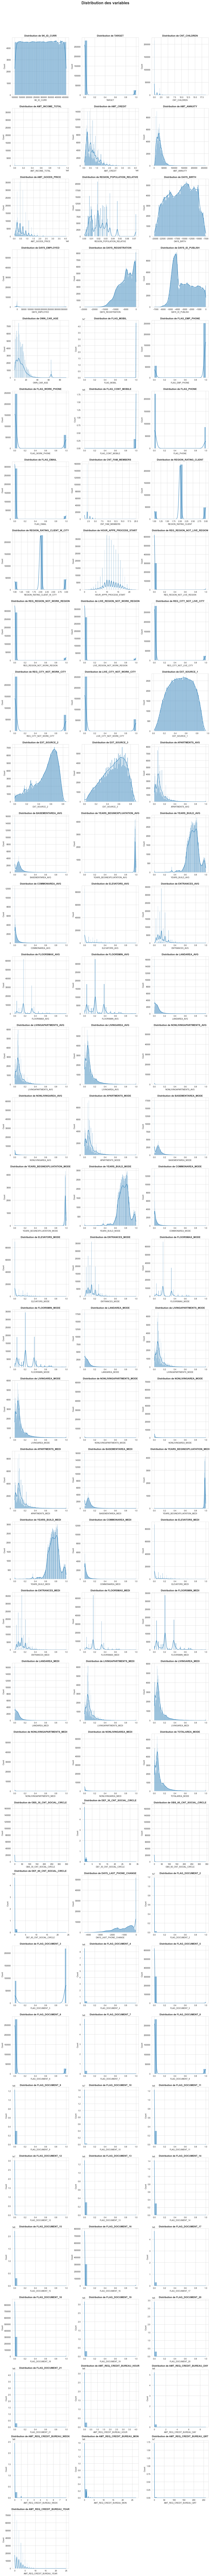

In [147]:
df_num = application_train.select_dtypes(include='number')
num_cols = df_num.shape[1]  # Nombre de colonnes dans df_num
num_rows = (num_cols - 1) // 3 + 1  # Calcul du nombre de lignes de sous-graphiques en fonction du nombre de colonnes

fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
axs = axs.ravel()

for i, col in enumerate(df_num.columns): 
    sns.histplot(df_num[col], ax=axs[i], kde=True)  # Utilisation de sns.histplot() au lieu de sns.distplot()
    axs[i].set_title(f'Distribution de {col}', fontweight="bold")

# Supprimer les sous-graphiques inutilisés s'il y a des colonnes manquantes pour remplir le dernier sous-graphique
for i in range(num_cols, num_rows * 3):
    fig.delaxes(axs[i])

fig.suptitle('Distribution des variables', fontweight="bold", fontsize=20, y=1.01)  # Ajustement de la position verticale du titre
plt.tight_layout()  # Ajustement automatique des espacements entre les sous-graphiques
plt.show()


## <a id='6.2'>6.2 Distribution des variables: Test de normalité (Kolmogorov-Smirnov) </a>

- H0 : les valeurs du feauture  sont issus d'une population normalement distribuée.
- H1 :  les valeurs du features ne sont PAS issus d'une population normalement distribuée

In [148]:
import scipy.stats as stats

df_num = application_train.select_dtypes(include='number')
alpha = 0.05

print('********************************************************************************')
print('Etude de la normalité')
print('********************************************************************************\n\n')

for i in range(len(df_num.columns)):
    print('---------------------------------')
    print('Variable {} : '.format(df_num.columns[i]))
    print('---------------------------------')
    D_obs, pvalue = stats.kstest(df_num[df_num.columns[i]], 'norm')
    print('D_obs= {}\nP-value= {}'.format(D_obs, pvalue))
    if pvalue < alpha: 
        print('''P-value<{} L'hypothèse nulle H0 est rejétée\n => la distribution ne suit pas une loi normale'''
              .format(alpha, df_num.columns[i]))  # Correction ici
    else: 
        print('''On ne peut pas rejeter l'hypothèse H0''')
    print('\n')


********************************************************************************
Etude de la normalité
********************************************************************************


---------------------------------
Variable SK_ID_CURR : 
---------------------------------
D_obs= 1.0
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable TARGET : 
---------------------------------
D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable CNT_CHILDREN : 
---------------------------------
D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable AMT_INCOME_TOTAL : 
---------------------------------
D_obs= 1.0
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribut

D_obs= nan
P-value= nan
On ne peut pas rejeter l'hypothèse H0


---------------------------------
Variable LANDAREA_AVG : 
---------------------------------
D_obs= nan
P-value= nan
On ne peut pas rejeter l'hypothèse H0


---------------------------------
Variable LIVINGAPARTMENTS_AVG : 
---------------------------------
D_obs= nan
P-value= nan
On ne peut pas rejeter l'hypothèse H0


---------------------------------
Variable LIVINGAREA_AVG : 
---------------------------------
D_obs= nan
P-value= nan
On ne peut pas rejeter l'hypothèse H0


---------------------------------
Variable NONLIVINGAPARTMENTS_AVG : 
---------------------------------
D_obs= nan
P-value= nan
On ne peut pas rejeter l'hypothèse H0


---------------------------------
Variable NONLIVINGAREA_AVG : 
---------------------------------
D_obs= nan
P-value= nan
On ne peut pas rejeter l'hypothèse H0


---------------------------------
Variable APARTMENTS_MODE : 
---------------------------------
D_obs= nan
P-value= nan
On ne

D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable FLAG_DOCUMENT_14 : 
---------------------------------
D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable FLAG_DOCUMENT_15 : 
---------------------------------
D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable FLAG_DOCUMENT_16 : 
---------------------------------
D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


---------------------------------
Variable FLAG_DOCUMENT_17 : 
---------------------------------
D_obs= 0.5
P-value= 0.0
P-value<0.05 L'hypothèse nulle H0 est rejétée
 => la distribution ne suit pas une loi normale


------------

* Aucune distribution des variables ne suit la loi nornale

## <a id='7'>7. Correlations entre les variables : corrélation de Sperman </a>

In [149]:
application_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801       -9461   
1       House / apartment                    0.003541      -16765   
2       House / apartment                    0.010032      -19046   
3       House / apartment                    0.008019      -19005   
4       House / apartment                    0.028663      -19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561       -9327   
307507  House / apartment       

In [150]:
df = application_train.select_dtypes(include=np.number)
data = [
    go.Heatmap(
        z=df.corr(method='spearman').values,  # Utilisation du coefficient de Spearman
        x=df.columns.values,
        y=df.columns.values,
        colorscale='Viridis',
        reversescale=False,
        text=df.corr().values,
        opacity=1.0
    )
]

layout = go.Layout(
    title='Corrélation entre les features (Spearman)',
    xaxis=dict(ticks='', nticks=36),
    yaxis=dict(ticks=''),
    width=900,
    height=700,
    margin=dict(
        l=240,
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')


## <a id='8'>8. Conclusion </a>

Apès l'EDA, nous avions detecté quelquespProblèmes liés aux données :

Les données souffrent d'un déséquilibre entre les classes .
Les Valeurs manquantes avec différentes proportions .
Des valeurs aberrantes dans de nombreuses features .
Des features numériques avec différentes échelles .
Les 20 FLAG_DOCUMENT caractéristiques ayant un faible impact, à traiter.